In [1]:
import torchvision
print(torchvision.__version__)

0.19.0


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os
from pathlib import Path
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [3]:
def split_folder(folder):
    data = []
    sub_folder = list(sorted(os.listdir(folder)))
    sub_folder_path = [os.path.join(folder, sub) for sub in sub_folder]
    file = ["jpg", "png", "jpeg"]
    for folder_path in sub_folder_path:
        image = list(sorted(os.listdir(folder_path)))
        for img in image:
            img_path = os.path.join(folder_path, img)
            try:
                img_pil = Image.open(img_path)
                if img_pil.mode != "P" or img_pil.split(".")[-1] in file:
                    data.append(img_path)
            except:
                continue

    class_name = {i:label for i, label in enumerate(sub_folder)}
    return data, class_name

In [4]:
class MyDataSet(nn.Module):
    def __init__(self, folder, transforms=None):
        super(MyDataSet, self).__init__()
        self.image, self.class_name = split_folder(folder)
        self.transforms = transforms
        self.label_to_idx = {self.class_name[i]: i for i in range(len(self.class_name))}
    def load_image(self, index):
        img = Image.open(self.image[index])
        img = img.convert("RGB")
        return img
    def __len__(self):
        return len(self.image)
    def __getitem__(self, index):
        img = self.load_image(index)
        label = Path(self.image[index]).parent.name
        if self.transforms is not None:
            img = self.transforms(img)
            return img, self.label_to_idx[label]
        return img, self.label_to_idx[label]

In [5]:
img_size = 224
train_transform = transforms.Compose([transforms.Resize((img_size,img_size)),
                                    transforms.CenterCrop(img_size),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_transform = transforms.Compose([transforms.Resize((img_size,img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [6]:
train_data = MyDataSet(folder="/kaggle/input/vn-moto-dataset", transforms=train_transform)
val_data = MyDataSet(folder="/kaggle/input/tiny-moto-dataset", transforms=val_transform)

In [7]:
print(f"Class name: {train_data.class_name}")
print(f"Shape of image 1: {train_data[0][0].shape}")
print(f"Label: {train_data[0][1]}")

Class name: {0: 'Honda', 1: 'Others', 2: 'Suzuki', 3: 'VinFast', 4: 'Yamaha'}
Shape of image 1: torch.Size([3, 224, 224])
Label: 0


# 1. Prepare Dataset

In [8]:
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
val_dataloader = DataLoader(dataset=val_data,
                           batch_size=BATCH_SIZE,
                           shuffle=True)

# 2. Data Augmentation

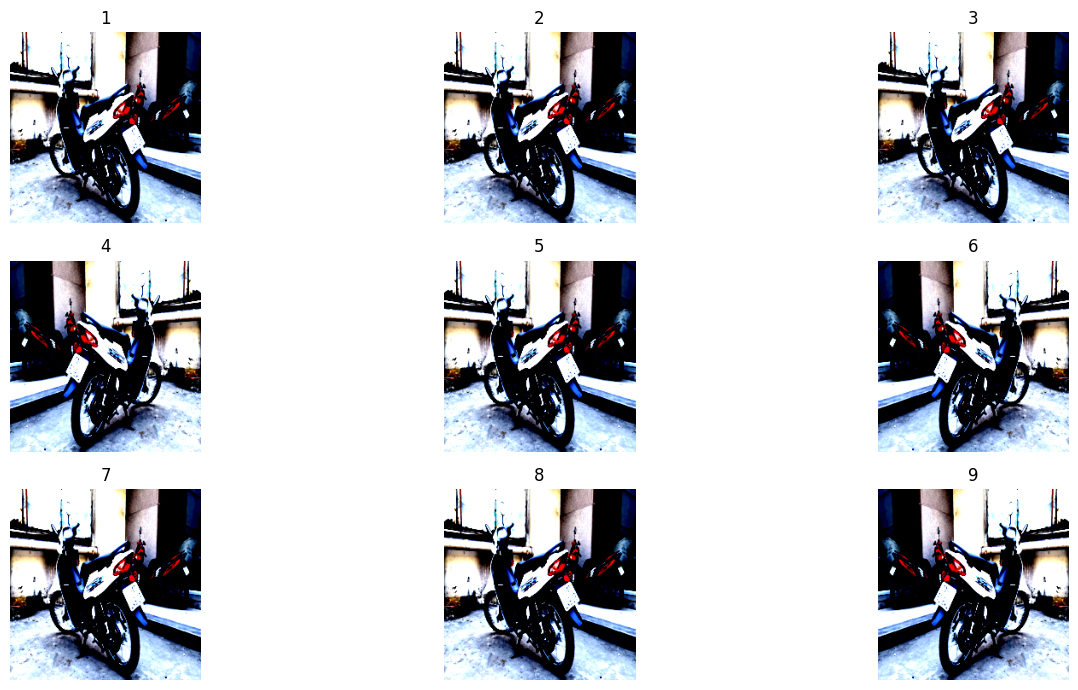

In [9]:
plt.figure(figsize=(15, 7))
for i in range(1, 10):
    image_numpy = torch.Tensor.numpy(train_data[0][0].permute(1, 2, 0))
    plt.subplot(3, 3, i)
    plt.imshow(image_numpy)
    plt.title(f"{i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 3. Model

In [10]:
class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """

    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape), requires_grad=True)
        self.bias = nn.Parameter(torch.zeros(normalized_shape), requires_grad=True)
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise ValueError(f"not support data format '{self.data_format}'")
        self.normalized_shape = (normalized_shape,)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            # [batch_size, channels, height, width]
            mean = x.mean(1, keepdim=True)
            var = (x - mean).pow(2).mean(1, keepdim=True)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

In [11]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


In [12]:
class GRN(nn.Module):
    """ GRN (Global Response Normalization) layer
    """
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        Gx = torch.norm(x, p=2, dim=(1,2), keepdim=True)
        Nx = Gx / (Gx.mean(dim=-1, keepdim=True) + 1e-6)
        return self.gamma * (x * Nx) + self.beta + x

In [13]:
class Block(nn.Module):
    """ ConvNeXtV2 Block.
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
    """
    def __init__(self, dim, drop_path=0.):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        # self.grn = GRN(4 * dim)
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        # x = self.grn(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

In [14]:
class ConvNextV2(nn.Module):
    """ ConvNeXt V2
        
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], 
                 drop_path_rate=0., head_init_scale=1.
                 ):
        super().__init__()
        self.depths = depths
        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j]) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)
        
    def forward(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        x = self.norm(x.mean([-2, -1]))
        x = self.head(x)

        return x

In [15]:
torch.manual_seed(42)
NUM_CLASSES = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
model_cls = ConvNextV2(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], num_classes=NUM_CLASSES)
weight_dict = torch.load('/kaggle/input/model_new/pytorch/default/1/pre_last_model_50.pth',
                         map_location=device)

/tmp/ipykernel_23/2721981025.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight_dict = torch.load('/kaggle/input/model_new/pytorch/default/1/pre_last_model_50.pth',


In [16]:
weight_dict.keys()

odict_keys(['mask_token', 'encoder.downsample_layers.0.0.weight', 'encoder.downsample_layers.0.0.bias', 'encoder.downsample_layers.0.1.weight', 'encoder.downsample_layers.0.1.bias', 'encoder.downsample_layers.1.0.weight', 'encoder.downsample_layers.1.0.bias', 'encoder.downsample_layers.1.1.weight', 'encoder.downsample_layers.1.1.bias', 'encoder.downsample_layers.2.0.weight', 'encoder.downsample_layers.2.0.bias', 'encoder.downsample_layers.2.1.weight', 'encoder.downsample_layers.2.1.bias', 'encoder.downsample_layers.3.0.weight', 'encoder.downsample_layers.3.0.bias', 'encoder.downsample_layers.3.1.weight', 'encoder.downsample_layers.3.1.bias', 'encoder.stages.0.0.dwconv.weight', 'encoder.stages.0.0.dwconv.bias', 'encoder.stages.0.0.norm.weight', 'encoder.stages.0.0.norm.bias', 'encoder.stages.0.0.pwconv1.weight', 'encoder.stages.0.0.pwconv1.bias', 'encoder.stages.0.0.pwconv2.weight', 'encoder.stages.0.0.pwconv2.bias', 'encoder.stages.0.0.grn.gamma', 'encoder.stages.0.0.grn.beta', 'encode

In [17]:
for k in list(weight_dict.keys()):
    if 'decoder' in k or 'mask_token'in k or 'proj' in k or 'pred' in k:
        print(f"Removing key {k} from pretrained checkpoint")
        del weight_dict[k]

Removing key mask_token from pretrained checkpoint
Removing key proj.weight from pretrained checkpoint
Removing key proj.bias from pretrained checkpoint
Removing key decoder.0.dwconv.weight from pretrained checkpoint
Removing key decoder.0.dwconv.bias from pretrained checkpoint
Removing key decoder.0.norm.weight from pretrained checkpoint
Removing key decoder.0.norm.bias from pretrained checkpoint
Removing key decoder.0.pwconv1.weight from pretrained checkpoint
Removing key decoder.0.pwconv1.bias from pretrained checkpoint
Removing key decoder.0.grn.gamma from pretrained checkpoint
Removing key decoder.0.grn.beta from pretrained checkpoint
Removing key decoder.0.pwconv2.weight from pretrained checkpoint
Removing key decoder.0.pwconv2.bias from pretrained checkpoint
Removing key pred.weight from pretrained checkpoint
Removing key pred.bias from pretrained checkpoint


In [18]:
updated_weight_dict = {}

In [19]:
for k,v in weight_dict.items():
    if k.startswith("encoder."):
        updated_weight_dict[k[len("encoder."):]]= v
    else:
        updated_weight_dict[k] = v

In [20]:
model_cls.load_state_dict(updated_weight_dict, strict=False)

_IncompatibleKeys(missing_keys=['norm.weight', 'norm.bias', 'head.weight', 'head.bias'], unexpected_keys=['stages.0.0.grn.gamma', 'stages.0.0.grn.beta', 'stages.0.1.grn.gamma', 'stages.0.1.grn.beta', 'stages.0.2.grn.gamma', 'stages.0.2.grn.beta', 'stages.1.0.grn.gamma', 'stages.1.0.grn.beta', 'stages.1.1.grn.gamma', 'stages.1.1.grn.beta', 'stages.1.2.grn.gamma', 'stages.1.2.grn.beta', 'stages.2.0.grn.gamma', 'stages.2.0.grn.beta', 'stages.2.1.grn.gamma', 'stages.2.1.grn.beta', 'stages.2.2.grn.gamma', 'stages.2.2.grn.beta', 'stages.2.3.grn.gamma', 'stages.2.3.grn.beta', 'stages.2.4.grn.gamma', 'stages.2.4.grn.beta', 'stages.2.5.grn.gamma', 'stages.2.5.grn.beta', 'stages.2.6.grn.gamma', 'stages.2.6.grn.beta', 'stages.2.7.grn.gamma', 'stages.2.7.grn.beta', 'stages.2.8.grn.gamma', 'stages.2.8.grn.beta', 'stages.2.9.grn.gamma', 'stages.2.9.grn.beta', 'stages.2.10.grn.gamma', 'stages.2.10.grn.beta', 'stages.2.11.grn.gamma', 'stages.2.11.grn.beta', 'stages.2.12.grn.gamma', 'stages.2.12.grn.be

In [21]:
for name, para in model_cls.named_parameters():
    if 'head' not in name:
        para.requires_grad_(False)
    else:
        print("training {}".format(name))

training head.weight
training head.bias


In [22]:
torch.manual_seed(42)
image = train_data[0][0]
model_cls, image = model_cls.to(device), image.to(device)
print(model_cls(image.unsqueeze(0)))

tensor([[-0.0364, -0.5479,  0.0315,  0.4817, -0.3270]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [23]:
model_cls

ConvNextV2(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(512, 1024, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=128, out_features=512, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=512, out_features=128, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1

In [24]:
from torchinfo import summary
print(summary(model_cls))

Layer (type:depth-idx)                   Param #
ConvNextV2                               --
├─ModuleList: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  (6,272)
│    │    └─LayerNorm: 3-2               (256)
│    └─Sequential: 2-2                   --
│    │    └─LayerNorm: 3-3               (256)
│    │    └─Conv2d: 3-4                  (131,328)
│    └─Sequential: 2-3                   --
│    │    └─LayerNorm: 3-5               (512)
│    │    └─Conv2d: 3-6                  (524,800)
│    └─Sequential: 2-4                   --
│    │    └─LayerNorm: 3-7               (1,024)
│    │    └─Conv2d: 3-8                  (2,098,176)
├─ModuleList: 1-2                        --
│    └─Sequential: 2-5                   --
│    │    └─Block: 3-9                   (138,368)
│    │    └─Block: 3-10                  (138,368)
│    │    └─Block: 3-11                  (138,368)
│    └─Sequential: 2-6                   --
│    │  

# 4. Training

In [25]:
def accuracy_fn(y_true, y_pred):
    acc = torch.eq(y_true, y_pred).sum().item()
    return (acc / len(y_true)) 

In [26]:
def train_step(train_dataloader, loss_fn, optimizer, device, model):
    model.train()
    model = model.to(device)
    train_loss, train_acc = 0, 0
    for batch, (image, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        image, label = image.to(device), label.to(device)
        y_logits = model(image)
        loss = loss_fn(y_logits, label)
        y_pred = torch.argmax(y_logits, dim=1)
        acc = accuracy_fn(label, y_pred)
        train_loss += loss
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    return train_loss, train_acc

In [27]:
def evaluate(val_dataloader, loss_fn, device, model):
    model.eval()
    model = model.to(device)
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for image, label in val_dataloader:
            image, label = image.to(device), label.to(device)
            y_logits = model(image)
            y_pred = torch.argmax(y_logits, dim=1)
            loss = loss_fn(y_logits, label)
            acc = accuracy_fn(label, y_pred)
            val_loss += loss
            val_acc += acc
    
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader) 
    
        return val_loss, val_acc

In [28]:
def create_lr_scheduler(optimizer,
                        num_step: int,
                        epochs: int,
                        warmup=True,
                        warmup_epochs=1,
                        warmup_factor=1e-3,
                        end_factor=1e-6):
    assert num_step > 0 and epochs > 0
    if warmup is False:
        warmup_epochs = 0

    def f(x):
        if warmup is True and x <= (warmup_epochs * num_step):
            alpha = float(x) / (warmup_epochs * num_step)
            return warmup_factor * (1 - alpha) + alpha
        else:
            current_step = (x - warmup_epochs * num_step)
            cosine_steps = (epochs - warmup_epochs) * num_step
            return ((1 + math.cos(current_step * math.pi / cosine_steps)) / 2) * (1 - end_factor) + end_factor

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=f)


In [29]:
epochs = 40
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_cls.parameters(),
                            lr=0.0001,
                            weight_decay=1e-5)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                               step_size=3,
#                                               gamma=0.1)
lr_scheduler = create_lr_scheduler(optimizer, len(train_dataloader), epochs,
                                   warmup=True, warmup_epochs=1)

In [30]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                exist_ok=True)
MODEL_NAME = "model_cls.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}
best_acc = 0
patience = 0

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train_step(train_dataloader, loss_fn, optimizer,
                                      device, model_cls)
    lr_scheduler.step()
    
    val_loss, val_acc = evaluate(val_dataloader, loss_fn, device, model_cls)

    results["epoch"].append(epoch + 1)
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["val_loss"].append(val_loss.item() if isinstance(val_loss, torch.Tensor) else val_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["val_acc"].append(val_acc.item() if isinstance(val_acc, torch.Tensor) else val_acc)

    print(f"train loss: {train_loss:.4f} train acc: {train_acc:.4f} | val loss: {val_loss:.4f} val acc: {val_acc:.4f}")

    if best_acc < val_acc:
        torch.save(obj=model_cls.state_dict(),
                    f=MODEL_SAVE_PATH)
        best_acc = val_acc
        patience = 0
    else:
        patience += 1
        if patience >= 3:
            print("Accuracy does not improve in 3 epochs. Early Stopping!")
            break

Epoch 1/40


100%|██████████| 955/955 [04:48<00:00,  3.31it/s]


train loss: 1.7169 train acc: 0.1724 | val loss: 1.7132 val acc: 0.2193
Epoch 2/40


100%|██████████| 955/955 [04:45<00:00,  3.34it/s]


train loss: 1.6933 train acc: 0.1777 | val loss: 1.6835 val acc: 0.2204
Epoch 3/40


100%|██████████| 955/955 [04:41<00:00,  3.39it/s]


train loss: 1.6621 train acc: 0.1944 | val loss: 1.6537 val acc: 0.2237
Epoch 4/40


100%|██████████| 955/955 [04:40<00:00,  3.40it/s]


train loss: 1.6288 train acc: 0.2276 | val loss: 1.6199 val acc: 0.2445
Epoch 5/40


100%|██████████| 955/955 [04:42<00:00,  3.38it/s]


train loss: 1.6021 train acc: 0.2621 | val loss: 1.5939 val acc: 0.2577
Epoch 6/40


100%|██████████| 955/955 [04:42<00:00,  3.38it/s]


train loss: 1.5829 train acc: 0.2873 | val loss: 1.5767 val acc: 0.2654
Epoch 7/40


100%|██████████| 955/955 [04:46<00:00,  3.34it/s]


train loss: 1.5698 train acc: 0.2984 | val loss: 1.5552 val acc: 0.3202
Epoch 8/40


100%|██████████| 955/955 [04:47<00:00,  3.32it/s]


train loss: 1.5593 train acc: 0.3086 | val loss: 1.5459 val acc: 0.3300
Epoch 9/40


100%|██████████| 955/955 [04:47<00:00,  3.32it/s]


train loss: 1.5512 train acc: 0.3133 | val loss: 1.5307 val acc: 0.3388
Epoch 10/40


100%|██████████| 955/955 [04:42<00:00,  3.38it/s]


train loss: 1.5428 train acc: 0.3184 | val loss: 1.5223 val acc: 0.3410
Epoch 11/40


100%|██████████| 955/955 [04:40<00:00,  3.41it/s]


train loss: 1.5359 train acc: 0.3225 | val loss: 1.5044 val acc: 0.3487
Epoch 12/40


100%|██████████| 955/955 [04:41<00:00,  3.40it/s]


train loss: 1.5289 train acc: 0.3258 | val loss: 1.4959 val acc: 0.3509
Epoch 13/40


100%|██████████| 955/955 [04:50<00:00,  3.29it/s]


train loss: 1.5223 train acc: 0.3296 | val loss: 1.4903 val acc: 0.3575
Epoch 14/40


100%|██████████| 955/955 [04:47<00:00,  3.32it/s]


train loss: 1.5156 train acc: 0.3355 | val loss: 1.4800 val acc: 0.3651
Epoch 15/40


100%|██████████| 955/955 [04:47<00:00,  3.33it/s]


train loss: 1.5108 train acc: 0.3393 | val loss: 1.4757 val acc: 0.3673
Epoch 16/40


100%|██████████| 955/955 [04:51<00:00,  3.27it/s]


train loss: 1.5040 train acc: 0.3425 | val loss: 1.4709 val acc: 0.3640
Epoch 17/40


100%|██████████| 955/955 [04:47<00:00,  3.32it/s]


train loss: 1.4989 train acc: 0.3486 | val loss: 1.4699 val acc: 0.3662
Epoch 18/40


100%|██████████| 955/955 [04:45<00:00,  3.34it/s]


train loss: 1.4946 train acc: 0.3490 | val loss: 1.4642 val acc: 0.3750
Epoch 19/40


100%|██████████| 955/955 [04:46<00:00,  3.34it/s]


train loss: 1.4891 train acc: 0.3535 | val loss: 1.4522 val acc: 0.3969
Epoch 20/40


100%|██████████| 955/955 [04:46<00:00,  3.33it/s]


train loss: 1.4849 train acc: 0.3580 | val loss: 1.4527 val acc: 0.3936
Epoch 21/40


100%|██████████| 955/955 [04:45<00:00,  3.34it/s]


train loss: 1.4790 train acc: 0.3654 | val loss: 1.4491 val acc: 0.3947
Epoch 22/40


100%|██████████| 955/955 [04:46<00:00,  3.34it/s]


train loss: 1.4730 train acc: 0.3662 | val loss: 1.4486 val acc: 0.3936
Accuracy does not improve in 3 epochs. Early Stopping!


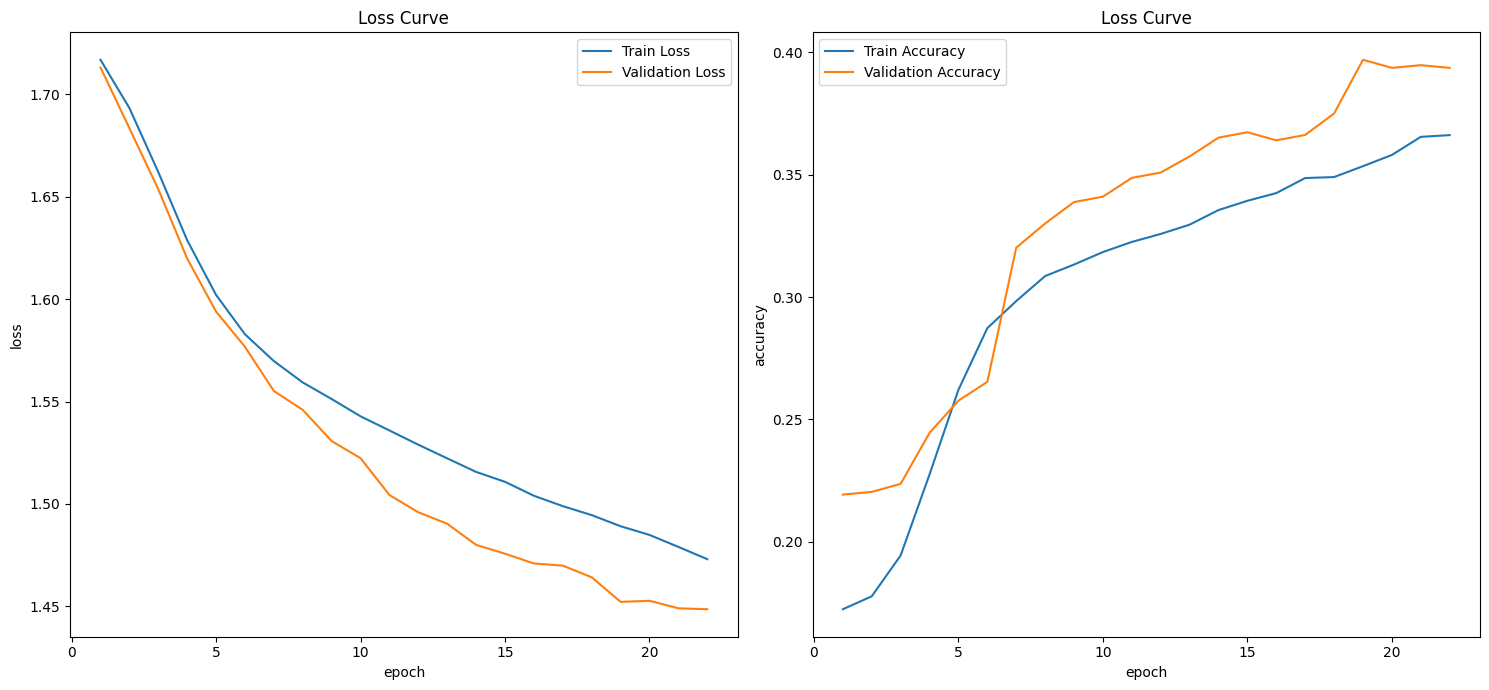

In [32]:
plt.figure(figsize=(15, 7))
epoch = results["epoch"]
loss = results["train_loss"]
acc = results["train_acc"]
val_loss = results["val_loss"]
val_acc = results["val_acc"]

plt.subplot(1, 2, 1)
plt.plot(epoch, loss, label="Train Loss")
plt.plot(epoch, val_loss, label="Validation Loss")
plt.title(f"Loss Curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch, acc, label="Train Accuracy")
plt.plot(epoch, val_acc, label="Validation Accuracy")
plt.title(f"Loss Curve")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("Learning_Curve.png")
plt.show()